# Goal

I've got the fasta formatted downloaded file of every single reviewed human protein annotation in uniprot. Lets see what kind of information we can get from those.

In [1]:
import pandas as pd
import os
import re
from Bio import SeqIO

In [2]:
prot_recs = [x for x in SeqIO.parse("data/uniprot_human_proteins_reviewed.fasta","fasta")]

In [3]:
prot_recs[0]

SeqRecord(seq=Seq('MAKRTKKVGIVGKYGTRYGASLRKMVKKIEISQHAKYTCSFCGKTKMKRRAVGI...KDQ', SingleLetterAlphabet()), id='sp|P61513|RL37A_HUMAN', name='sp|P61513|RL37A_HUMAN', description='sp|P61513|RL37A_HUMAN 60S ribosomal protein L37a OS=Homo sapiens OX=9606 GN=RPL37A PE=1 SV=2', dbxrefs=[])

### Extracting protein name, sequence

Lets pull those out of every seq record and store into a dataframe.

In [4]:
def recordParser(record):
    """Return an array of values for each sequence record.
    [id, protein_name, protein_sequence]"""
    return [record.name, str(record.seq)]

prot_df = pd.DataFrame([recordParser(x) for x in prot_recs],columns=["protein_name","sequence"])

In [5]:
prot_df.shape,display(prot_df.sample(5))

protein_name  \
13551  sp|Q13613|MTMR1_HUMAN   
13827  sp|Q5TI25|NBPFE_HUMAN   
18138  sp|Q9BZ71|PITM3_HUMAN   
17825  sp|O43688|PLPP2_HUMAN   
5446   sp|Q96HA4|CA159_HUMAN   

                                                sequence  
13551  MDRPAAAAAAGCEGGGGPNPGPAGGRRPPRAAGGATAGSRQPSVET...  
13827  MLRNERQFKEEKLAEQLKQAEELRQYKVLVHAQERELTQLREKLRE...  
18138  MAKAGRAGGPPPGGGAPWHLRNVLSDSVESSDDEFFDAREEMAEGK...  
17825  MQRRWVFVLLDVLCLLVASLPFAILTLVNAPYKRGFYCGDDSIRYP...  
5446   MALRHLALLAGLLVGVASKSMENTVTRNSTAVINTQAEGTLSPPGL...

((20394, 2), None)

# Other protein characteristics (primary)

include Molecular weight, isoelectric point, amino acid content (count, %), aromaticity, instability index, secondary structure fraction, molar extinction coefficient.

Lets extract all of those from our sequences!

In [6]:
amino_acids = ["A","R","H","K","D","E","S","T","N","Q","C","G","P","V","I","L","M","F","Y","W"]
len(amino_acids)

20

In [41]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def protSeqFeatExtractor(sequence):
    x = ProteinAnalysis(sequence)
    
    # Get molecular weight
    mol_weight = x.molecular_weight()
    
    # Get aromaticity
    aromaticit = x.aromaticity()
    
    # Get instability index
    try:
        #seleno cysteine was found in a single protein
        instabilit = x.instability_index()
    except KeyError:
        x_sub = ProteinAnalysis(sequence.replace("U","C"))
        instabilit = x_sub.instability_index()
        
    # Get isoelectric point
    isoe_point = x.isoelectric_point()
    
    # Get secondary structure fraction
    sec_struc_frac = x.secondary_structure_fraction()
    helix_frac = sec_struc_frac[0]
    turn_frac = sec_struc_frac[1]
    sheet_frac = sec_struc_frac[2]
    
    # Get molar extinction coefficients
    epsilon_prot = x.molar_extinction_coefficient()
    reduced = epsilon_prot[0]
    disulfide = epsilon_prot[1]
    
    # Collect results so far
    results = [mol_weight, aromaticit, instabilit, isoe_point, helix_frac, turn_frac, sheet_frac,
           reduced, disulfide]
    
    # Collect column names so far
    columns = ["mol_weight","aromaticity","instability_index","isoelectric_point","helix_fraction",
            "turn_fraction","sheet_fraction","num_reduced_cysteines","num_disulfide_bridges"]
    
    # Get amino acid breakdown
    aa_percs = x.get_amino_acids_percent()
    aa_counts = x.count_amino_acids()
    
    for aa in amino_acids:
        results.append(aa_percs[aa])
        columns.append("aa_perc_"+aa)
        results.append(aa_counts[aa])
        columns.append("aa_count_"+aa)
    
    # Return everything
    return results, columns

prot_feat_extract_result = prot_df['sequence'].apply(protSeqFeatExtractor).values.tolist()

In [54]:
prot_feats = [x[0] for x in prot_feat_extract_result]
prot_feat_cols = prot_feat_extract_result[0][1]
prot_feats_df = pd.DataFrame(
    prot_feats,
    columns=prot_feat_cols
)

prot_df_features = pd.concat([prot_df,prot_feats_df],axis=1).set_index(["protein_name","sequence"])
prot_feat_cols.sort()
prot_df_features = prot_df_features[prot_feat_cols].reset_index()

In [55]:
prot_df_features.sample(5)

protein_name  \
971    sp|Q9UMZ3|PTPRQ_HUMAN   
9870    sp|Q04206|TF65_HUMAN   
988     sp|Q5T6V5|QSPP_HUMAN   
16943  sp|Q9Y2A7|NCKP1_HUMAN   
9477   sp|Q9BZS9|YG041_HUMAN   

                                                sequence   aa_count_A  \
971    MKKVPIKPEQPEKLRAFNISTHSFSLHWSLPSGHVERYQVDLVPDS...  260920.5609   
9870   MDELFPLIFPAEPAQASGPYVEIIEQPKQRGMRFRYKCEGRSAGSI...   60218.4657   
988    MDGLLNPRESSKFIAENSRDVFIDSGGVRRVAELLLAKAAGPELRV...   39028.0833   
16943  MSRSVLQPSQQKLAEKLTILNDRGVGMLTRLYNIKKACGDPKAKPS...  128788.5858   
9477   MPYDQDSFSTLLGFLQASRKYSEFTLKCPICIYVPCQCFAVGFLKQSDQ    5618.4598   

       aa_count_C  aa_count_D  aa_count_E  aa_count_F  aa_count_G  aa_count_H  \
971      0.100343   36.519048    5.568054    0.324185    0.265437    0.193396   
9870     0.065336   54.435771    5.458191    0.245009    0.294011    0.239564   
988      0.102639   29.915279    5.610046    0.343109    0.199413    0.281525   
16943    0.086879   50.548156    6.181824    0.332447    0.195035    0.299645   
9477     0.163265   57.810204    5.909363    0.346939    0.204082    0.183673   

       aa_count_I      ...        aa_perc_Y  aromaticity  helix_fraction  \
971        343910      ...         0.070755          165        0.015009   
9870        23380      ...         0.078040           43        0.018149   
988         60850      ...         0.117302           40        0.017595   
16943      102110      ...         0.122340          138        0.040780   
9477         4470      ...         0.102041            5        0.020408   

       instability_index  isoelectric_point  mol_weight  \
971                   35           0.039451          92   
9870                  10           0.041742          23   
988                    6           0.038123          13   
16943                 46           0.045213          51   
9477                   1           0.102041           5   

       num_disulfide_bridges  num_reduced_cysteines  sheet_fraction  \
971                 0.046741                    109        0.014151   
9870                0.021779                     12        0.001815   
988                 0.043988                     15        0.020528   
16943               0.034574                     39        0.007092   
9477                0.061224                      3        0.000000   

       turn_fraction  
971               33  
9870               1  
988                7  
16943              8  
9477               0  

[5 rows x 51 columns]

I'm curious how the data are related at the moment, lets see what kind of relationships between the variables (disregarding the amino acid onces) with a visualization.

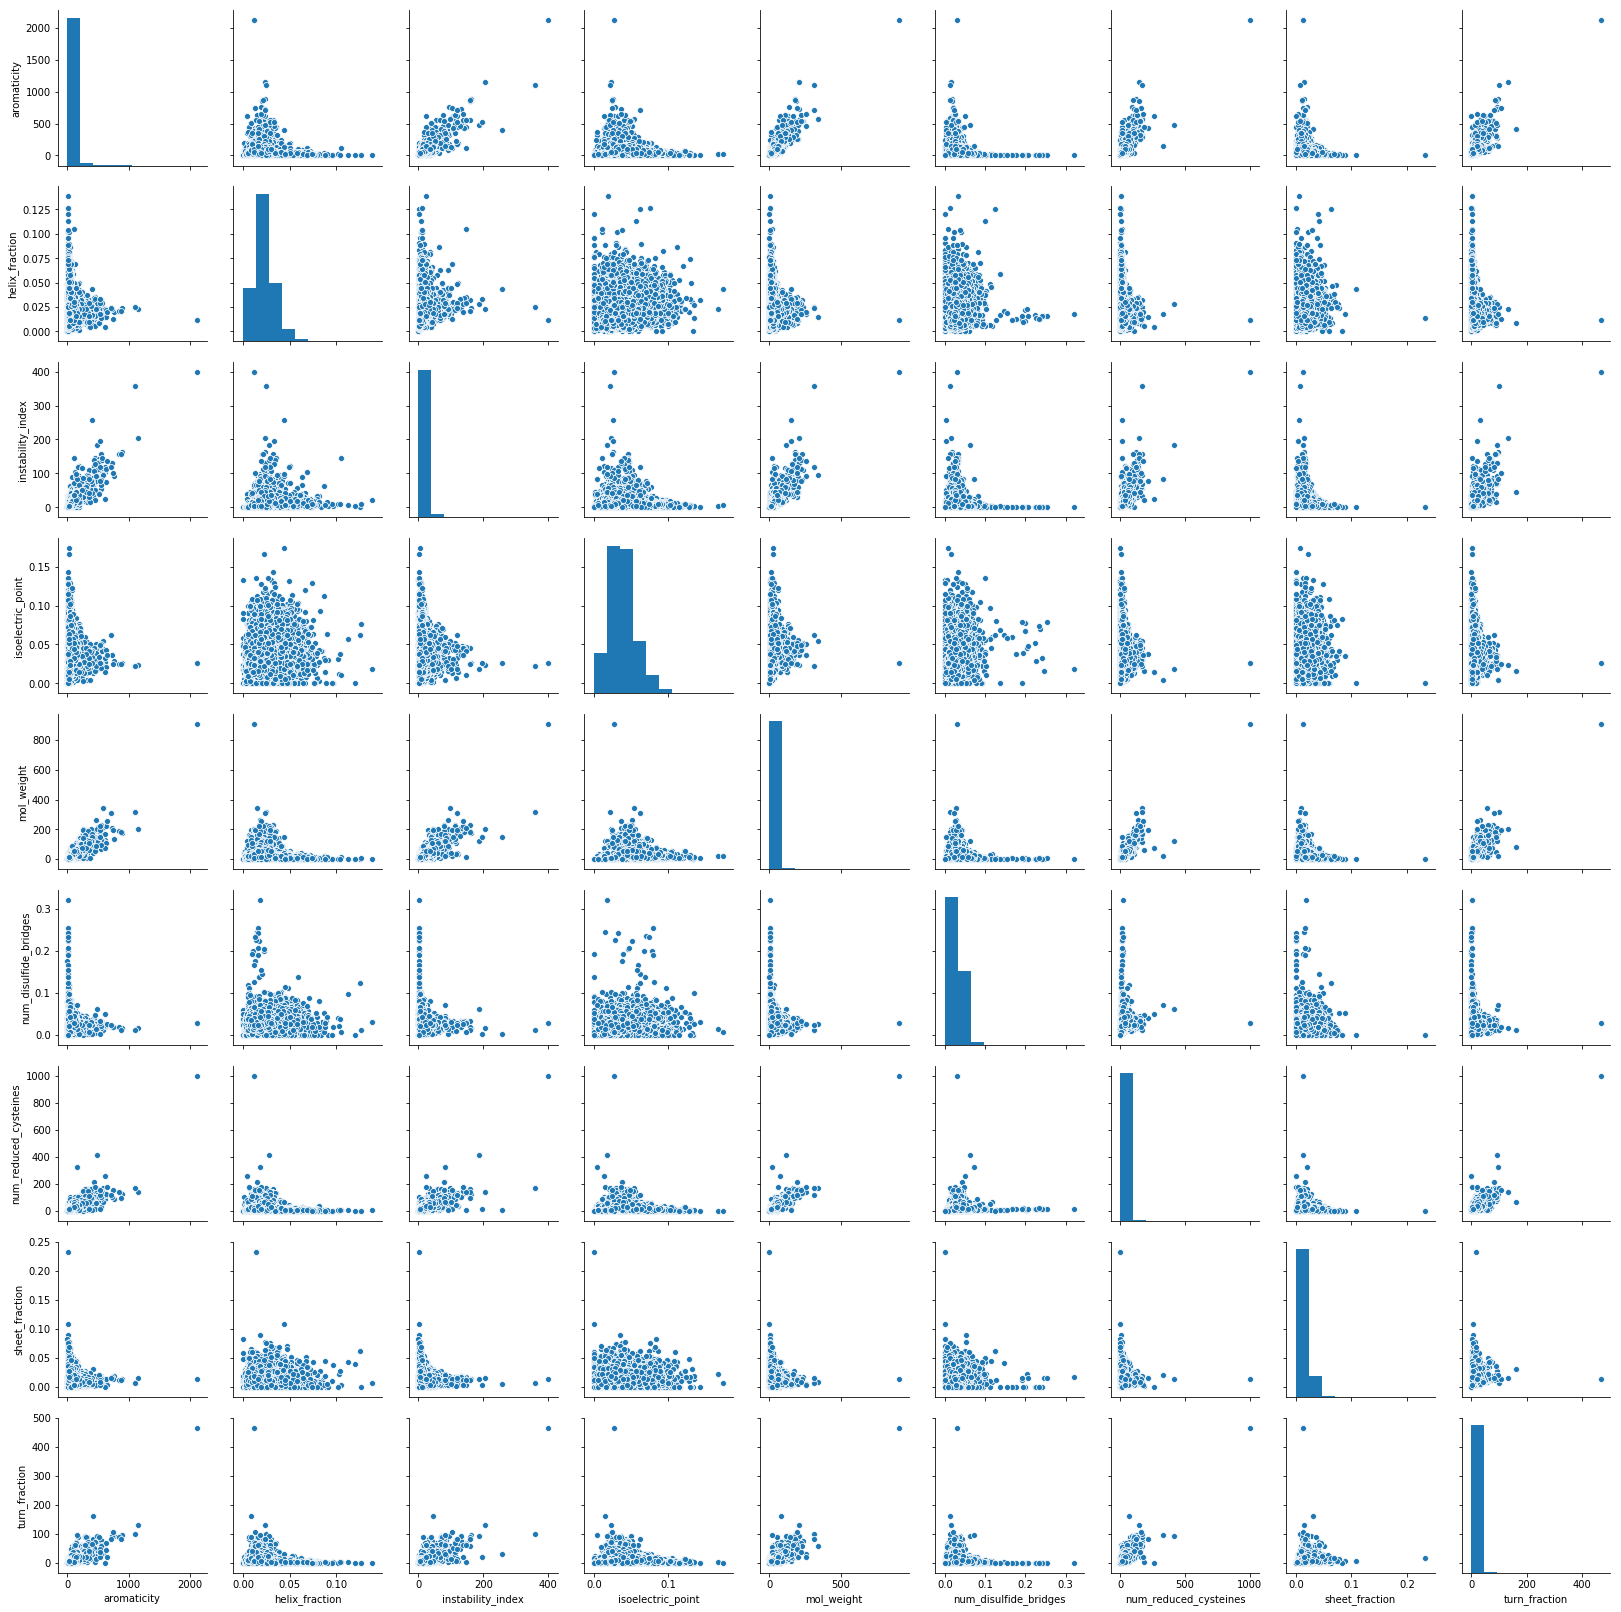

In [56]:
import seaborn as sns
from matplotlib import pyplot as plt

graph_cols = [x for x in prot_feat_cols if 'count' not in x and 'perc' not in x]

pair_fig = sns.pairplot(prot_df_features[graph_cols])
pair_fig.savefig("protein_pairplot.png", dpi=200)

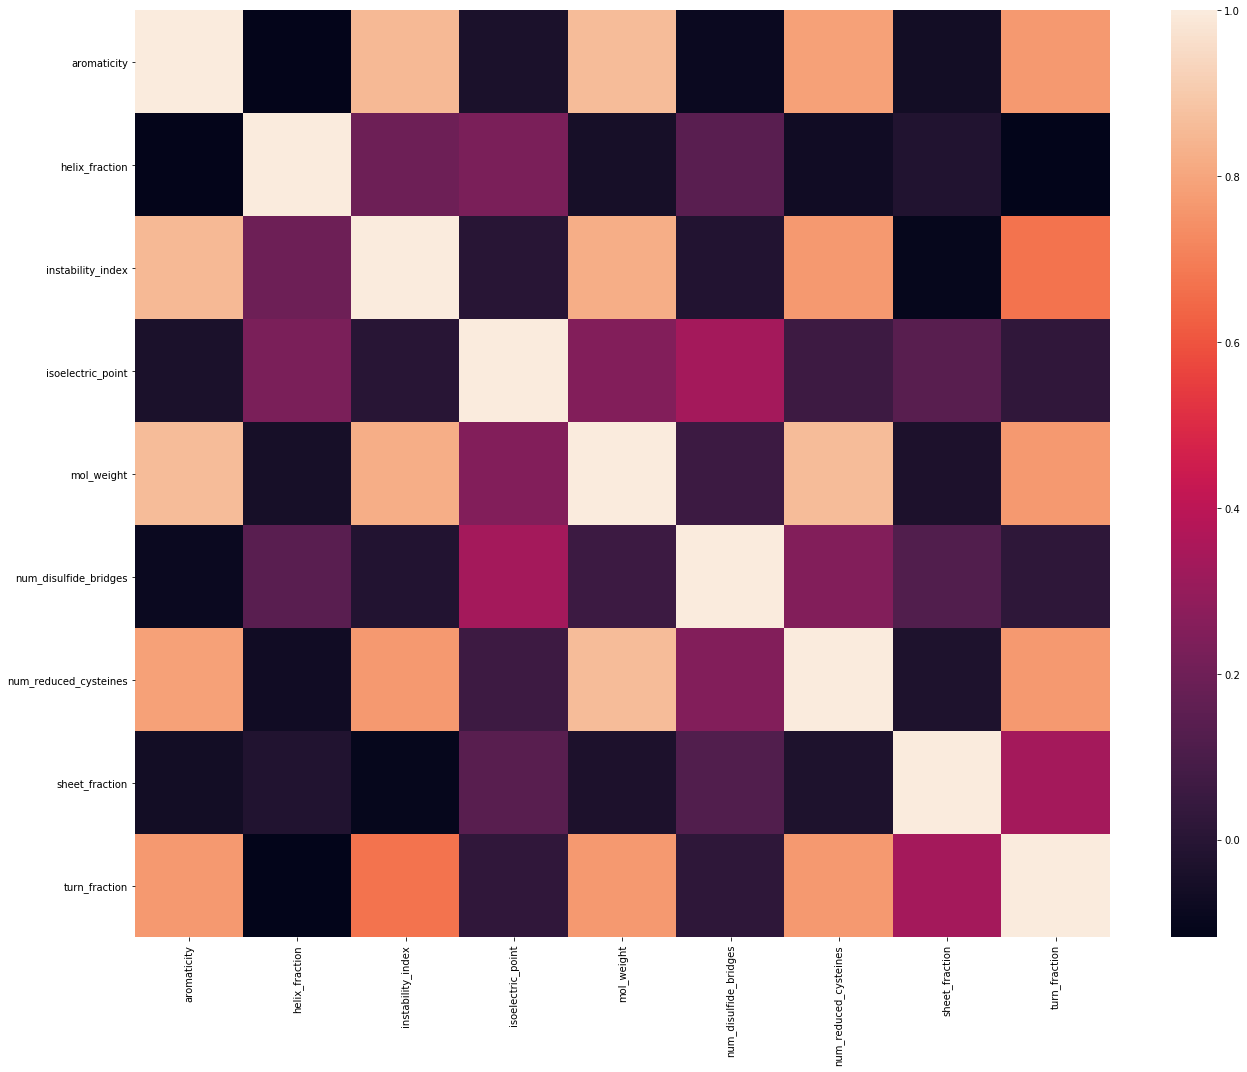

In [59]:
heatfig, heatax = plt.subplots(figsize=(19,15))

corr_cols = [x for x in prot_df_features if 'count' not in x]

heat = sns.heatmap(prot_df_features[graph_cols].corr(),ax=heatax)
plt.tight_layout()
heatfig.savefig("protein_heatmap.png",dpi=200)